# Quicklook CUD

# <font color="blue"> Imports

In [1]:
%matplotlib inline
import h5py
import os
import time

# import seaborn as sns
import numpy as np
#import plotly.express as px

#from fpdf import FPDF

from matplotlib import pyplot as plt
from importlib import reload

from scipy.optimize import curve_fit
np.set_printoptions(suppress=True)

# <font color="blue">Parameter Selections</font>

In [2]:
file_dict= {
    "r22"  : "/Users/swasti/code/beamtest/run22-15MeV/2022-04-28_1022_1651155763_15MeVBeam_1hour_run22_tracker.CUD.h5",
    "r22a"  : "/Users/swasti/code/beamtest/run22-15MeV/beam-original/cud_combined.CUD.h5"
}

In [4]:
nrg_title_dict ={
    "r22": "r22_15MeV",
    "r22a": "r22_15MeV"
}

In [3]:
max_nrg_dict = {
    "r22":20000,
    "r22a":20000,
}

## <font color="navy">File Parameter</font>


In [5]:
run = 'r22a'
fname = file_dict[run]
fname

'/Users/swasti/code/beamtest/run22-15MeV/beam-original/cud_combined.CUD.h5'

In [6]:
fpath = fname[0:fname.rfind('/')+1]
file = h5py.File(fname,'r')

### test

In [8]:
run = 'r22a'
fname = file_dict[run]
file = h5py.File(fname,'r')


## <font color="navy">Histogram creating Parameters</font>

In [9]:
nrg = nrg_title_dict[run]
max_nrg_sel = max_nrg_dict[run]

# <font color="blue">Attributes</font> Quick Check

In [10]:
file.attrs.keys()

<KeysViewHDF5 ['cud_file_acd', 'cud_file_csi', 'cud_file_czt', 'cud_file_trg', 'cud_file_trk', 'gencud_version']>

In [11]:
dict(file['Events/TKR'].attrs.items())

{'trk_compair_daq_git_branch': 'raw2hdf-speedup',
 'trk_compair_daq_git_hash': '95b650495d4760b2acf2e7b46549e7420249e3fa',
 'trk_conv_l2tol3_ver': 's2.1',
 'trk_ecalib_file': 'TKR_EnergyCalibrationCoefficients_20220420.dat',
 'trk_l1tol2_ecal_func_version': '1.1',
 'trk_recording_start_time': '2022-04-28T14:22:43.883311Z',
 'trk_recording_stop_time': '2022-04-28T15:22:50.205179Z'}

# <font color="blue">Read Data
    
<font color="red">**NOTE:** We have two arrays. One for nrg deposited, and one for energy deposited in each sensor. The former would be summed for per event.

In [14]:
def get_trk_nrg(trk_nrg, evt_id):
    """Get tracker energy in (n_evt, energy) format.
    
    Parameters
    ----------
        trk_nrg : dataset
            trk energy => f_trk['Events/TKR/Energy'][...]
        evt_id : dataset
            event id dataset => evt_id = f_trk['Events/TKR/EventID'][...] 
    Returns
    -------
        Energy array in an (nevents, no.hits) shape. nohits here defined by max hit per event id
    """
    nrg_id = trk_nrg[:,0] # select the tracker energy id
    unique_nrgid, counts = np.unique(nrg_id, return_counts=True) # get unique eventid and the no. of counts
    new_energy_ar = np.zeros(shape=(evt_id.shape[0],max(counts))) # evt_id = unique event id

    print(unique_nrgid.shape[0])
    for u_id in range(unique_nrgid.shape[0]):
        print(u_id) if u_id%10000 == 0 else None
        tid = unique_nrgid[u_id]                # unique id.
        t_loc = np.where(nrg_id ==tid)          # find locations for the ids
        t_loc1 = np.where(tid == evt_id)        # find where the ids are in event ids.
        t_nrg= trk_nrg[t_loc[0],4]            # get the energies.
    
        for j in range(len((t_loc[0]))):
            new_energy_ar[t_loc1[0],j] = t_nrg[j]

    return new_energy_ar

In [15]:
def get_common_index(trk_evtid, czt_evtid, csi_evtid):
    """ Find the common index using the event id from three subsystems.

    Parameters
    ----------
    trk_evtid : Dataset of Event IDs from tracker
    czt_evtid : Dataset of Event IDs from CZT
    csi_evtid : Dataset of Event IDs from CSI

    Returns
    -------
        trk_cm_index: Intarr
            Array of common index selection for tracker
        czt_cm_index: Intarr
            Array of common index selection for Czt
        csi_cm_index: Intarr
            Array of common index selection for Csi
    """
    delme1, tra_in1, csi_in1 = np.intersect1d(trk_evtid,csi_evtid,
                                              return_indices=True) # common index between tra and csi
    delme2, tra_in2, czt_in1 = np.intersect1d(trk_evtid,czt_evtid,
                                              return_indices=True) # common index between tra and czt
    delme3, csi_in2, czt_in2 = np.intersect1d(csi_evtid,czt_evtid,
                                              return_indices=True) # common index between czt and csi

    trk_cm_index, delme4, delme5 = np.intersect1d(tra_in1, tra_in2,
                                                  return_indices=True)  # get the ARRAY of common index.
    csi_cm_index, delme6, delme7 = np.intersect1d(csi_in1, csi_in2,
                                                  return_indices=True)  # get the ARRAY of common index.
    czt_cm_index, delme8, delme9 = np.intersect1d(czt_in1, czt_in2,
                                                  return_indices=True)  # get the ARRAY of common index.

    return trk_cm_index, czt_cm_index, csi_cm_index

## Tracker needs special attention

In [16]:
trk_evtid= file['Events/TKR/EventID'][...]
trk_energy = file['Events/TKR/Energy'][...]
print(trk_evtid.shape, trk_energy.shape)

(968959,) (334597, 6)


In [17]:
Trk_nrg = trk_energy[:,4][...] # Individual Hit
Trk_ind_evtid = trk_energy[:,0][...]

In [18]:
unique_nrgid, counts = np.unique(Trk_ind_evtid, return_counts=True) # get unique eventid and the no. of counts
unique_nrgid.shape[0]

141284

In [19]:
new_Trk_nrg = np.zeros(shape=(unique_nrgid.shape[0],max(counts)))

In [20]:
#NOTE THIS STEP TAKES A WHILE...
for i in range(unique_nrgid.shape[0]):
# for i in range(10):
    t_loc = np.where( unique_nrgid[i]==Trk_ind_evtid)
    t_nrg = np.array(Trk_nrg[t_loc[0]])
    t_nrg.resize((max(counts),))
    new_Trk_nrg[i] = t_nrg


In [21]:
new_Trk_nrg.shape
unique_nrgid.shape

(141284,)

In [22]:
Trk_nrg_arr = new_Trk_nrg
Trk_nrg_sum_arr = Trk_nrg_arr.sum(axis = tuple(range(1,2)))

In [40]:
Czt_evtida = file['Events/CZT/EventID'][...]
Czt_evtid =Czt_evtida[np.where(Czt_evtida >0)]

Czt_nrga = file['Events/CZT/Energy'][...]
Czt_nrg = Czt_nrga[np.where(Czt_evtida >0)]

Czt_nrg_arr = Czt_nrg
Czt_nrg_sum_arr= Czt_nrg.sum(axis = tuple(range(1,3)) )
Czt_nrg_arr.shape

(972310, 16, 16)

In [41]:
Csi_nrg = file['Events/CsI/erg'][...]
Csi_nrg_arr = Csi_nrg
Csi_nrg_sum_arr = Csi_nrg.sum(axis = tuple(range(1,2)) )
Csi_nrg_arr.shape

(382051, 30)

# <font color='blue'> Plots


## <font color="navy"> Basic Filters and definitions

In [42]:


Trk_nrg_thr = 0.0
Czt_nrg_thr = 0.0
Csi_nrg_thr = 0.0

Trk_nrg_max = max_nrg_sel
Czt_nrg_max = max_nrg_sel
Csi_nrg_max = max_nrg_sel
#n_evts

## <font color='navy'> Histogram parameters

In [55]:
e_min = 100.0 
e_max = max_nrg_sel
bin_width = 10.00
n_bins = int((e_max-e_min)/bin_width)
n_bins, e_max

(1990, 20000)

In [56]:
x_label = "Energy (keV)"
y_label = "Counts "
p_title = f"Energy Spectra {nrg}({run})"

In [57]:
# Xlim
xlim_min = 0
xlim_max =  max_nrg_sel # KeV
xlim_max

20000

## <font color="navy">Energy Deposited in Each Sensor.


In [46]:
# trk_n_evts = Trk_nrg.shape[0]
czt_n_evts = Czt_nrg.shape[0]
csi_n_evts = Csi_nrg.shape[0]

In [47]:
Trk_nrg_list_ind = [] # individual!
Czt_nrg_list_ind = []
Csi_nrg_list_ind = []

counter1 = 0

trk_n_evts = trk_energy.shape
Trk_nrg_list_ind = trk_energy[:,4][...] # select the tracker energy id
# for i in range(trk_n_evts):
#     delme_nrg = 0.0

#     #Tracker
#     temp_nrg_arr = Trk_nrg_arr[i][...]
#     if (np.count_nonzero(temp_nrg_arr > 0.0)) :
#         temp_arr = temp_nrg_arr[np.where(temp_nrg_arr>0.0)]
#         for j in range(0,len(temp_arr),2):
#             Trk_nrg_list_ind.append(temp_arr[j])

for i in range(czt_n_evts):
    # CZT
    temp_nrg_arr = Czt_nrg_arr[i]
    if (np.count_nonzero(temp_nrg_arr > 0.0)) :
        temp_arr = temp_nrg_arr[np.where(temp_nrg_arr>0.0)]
        for j in range(len(temp_arr)):
            Czt_nrg_list_ind.append(temp_arr[j])

for i in range(csi_n_evts):
    # CSI
    temp_nrg_arr = Csi_nrg_arr[i]
    if (np.count_nonzero(temp_nrg_arr > 0.0)) :
        temp_arr = temp_nrg_arr[np.where(temp_nrg_arr>0.0)]
        for j in range(len(temp_arr)):
            Csi_nrg_list_ind.append(temp_arr[j])

### <font color='brown'>Plot : Energy Deposited in each Sensor

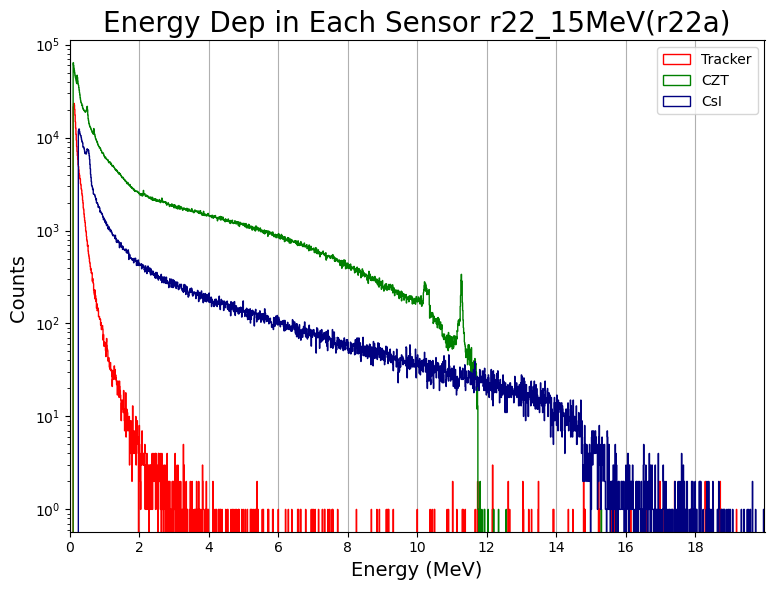

In [58]:
# Combined
plt.rcParams["figure.figsize"] = [8, 6]  
plt=reload(plt)
trk_hist, a, b= plt.hist(np.array(Trk_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red')
czt_hist, a, b=plt.hist(np.array(Czt_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='green')
csi_hist, a, b= plt.hist(np.array(Csi_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='navy')

plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(f"Energy Dep in Each Sensor {nrg}({run})", size = 20)

plt.xlim(xlim_min/1000.0,xlim_max/1000.0)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')

plt.xticks(np.arange(0,xlim_max/1000,2))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Ind_{run}_{nrg}MeV_log.jpeg")

20.0


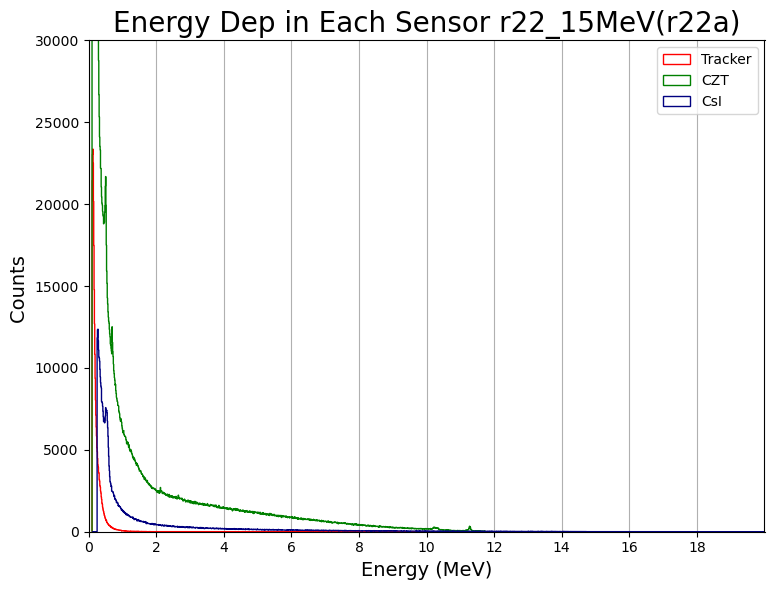

In [60]:
# Combined
plt.rcParams["figure.figsize"] = [8, 6]  
plt=reload(plt)
trk_hist, a, b= plt.hist(np.array(Trk_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red')
czt_hist, a, b=plt.hist(np.array(Czt_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='green')
csi_hist, a, b= plt.hist(np.array(Csi_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='navy')

plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(f"Energy Dep in Each Sensor {nrg}({run})", size = 20)
print(xlim_max/1000)
plt.xlim(xlim_min/1000.0,xlim_max/1000.0)
plt.ylim(0,30000)
#plt.ylim(0,2000)
# plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,20,2))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Ind_{run}_{nrg}MeV.jpeg")

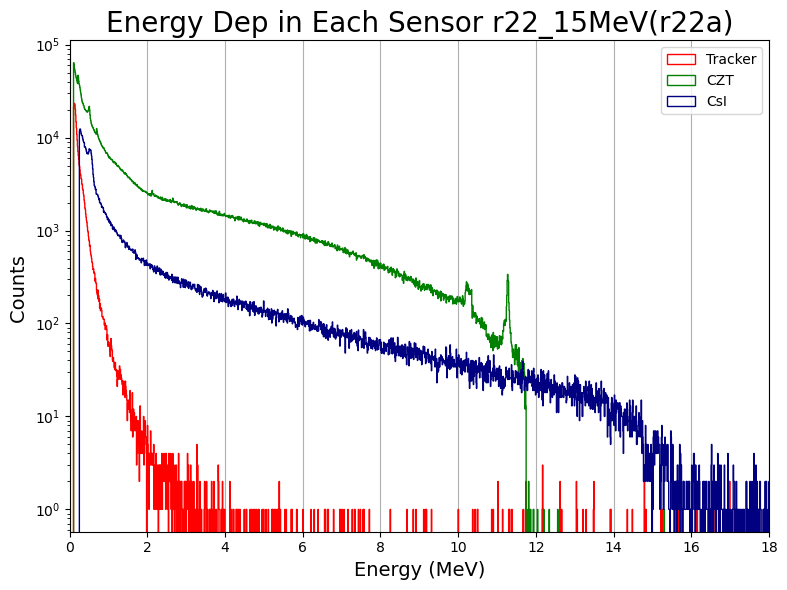

In [61]:
# Combined
plt.rcParams["figure.figsize"] = [8, 6]  
plt=reload(plt)
trk_hist, a, b= plt.hist(np.array(Trk_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red')
czt_hist, a, b=plt.hist(np.array(Czt_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='green')
csi_hist, a, b= plt.hist(np.array(Csi_nrg_list_ind)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='navy')

plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(f"Energy Dep in Each Sensor {nrg}({run})", size = 20)
plt.xlim(xlim_min/1000.0,3.5)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,20,2))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Ind_{run}b_{nrg}MeV_log.jpeg")

## Compare Tracker

## <font color='navy'> Total Energy Deposited

> **NOTE**: If not common event id.. we still need to add the energy per event wise.

* We would do a union of event ids to have a list of common event ids and loop (may be just the number.. )
* Then for each event id, we check if it is present in that subsystem before adding.

In [62]:
com_evt_flag = False

In [63]:
if com_evt_flag:
    Tot_nrg_list = []

    Trk_nrg_list = []
    Czt_nrg_list = []
    Csi_nrg_list = []

    for i in range(trk_n_evts):
        delme_nrg = 0.0

        temp_nrg = Trk_nrg_sum_arr[i]
        if temp_nrg > 0.0:
            temp_nrg = temp_nrg/2.0 
            Trk_nrg_list.append(temp_nrg)
            delme_nrg += temp_nrg

        temp_nrg = Czt_nrg_sum_arr[i]
        if temp_nrg > 0.0:
            temp_czt_tot = np.sum(temp_nrg)
            Czt_nrg_list.append(temp_czt_tot)
            delme_nrg += temp_nrg       

    
        temp_nrg = Csi_nrg_sum_arr[i]
        if temp_nrg > 0.0:
            temp_csi_tot = np.sum(temp_nrg)
            Csi_nrg_list.append(temp_csi_tot)        
            delme_nrg += temp_nrg  

        if delme_nrg > 0:
            Tot_nrg_list.append(delme_nrg)

else:
    print("ELSE RAN")
    Tot_nrg_list = []

    Trk_nrg_list = []
    Czt_nrg_list = []
    Csi_nrg_list = []
    
    trk_n_evts = unique_nrgid.shape[0]
    for i in range(trk_n_evts):
        temp_nrg = Trk_nrg_sum_arr[i]
        Trk_nrg_list.append(temp_nrg)
            
    for i in range(czt_n_evts):
        temp_nrg = Czt_nrg_sum_arr[i]
        if temp_nrg > 0.0:
            temp_czt_tot = np.sum(temp_nrg)
            Czt_nrg_list.append(temp_czt_tot)
            
            
    for i in range(csi_n_evts):
        temp_nrg = Csi_nrg_sum_arr[i]
        if temp_nrg > 0.0:
            temp_csi_tot = np.sum(temp_nrg)
            Csi_nrg_list.append(temp_csi_tot)        

ELSE RAN


In [64]:
file['Events/CsI/EventID/EventID']

<HDF5 dataset "EventID": shape (382051,), type "<i8">

In [65]:
file['Events/CZT/EventID']

<HDF5 dataset "EventID": shape (972318,), type "<u4">

In [74]:
#Get unique event ids
czt_evtida = file['Events/CZT/EventID'][...]
czt_evtid = czt_evtida[czt_evtida>0]
csi_evtid = file['Events/CsI/EventID/EventID'][...]
trk_evtid = unique_nrgid
delme_arr = np.union1d(trk_evtid,czt_evtid)
main_uniq_arr = np.union1d(delme_arr,csi_evtid)
unique_evts = main_uniq_arr
unique_evts

array([1.18325262e+08, 5.21109518e+08, 8.47253446e+08, ...,
       3.71615690e+09, 3.90748571e+09, 4.27802626e+09])

In [75]:
tloc = np.where(trk_evtid == 2147494189)
Trk_nrg_sum_arr.shape, trk_evtid.shape

((141284,), (141284,))

In [76]:
tot_nrg = []
print(unique_evts.shape[0])
for i in range(unique_evts.shape[0]):
    
    if i % 10000 == 0:
        print(i)
    tid = int(unique_evts[i])
    if tid == 0:
        continue
    
    delme_nrg = 0.0
    

    tloc = np.where(trk_evtid == tid)
    if len(tloc[0])>0:
        trk_nrg = Trk_nrg_sum_arr[tloc]
        delme_nrg+= trk_nrg
        
    tloc = np.where(czt_evtid == tid)
    if len(tloc[0])>0:
        czt_nrg = Czt_nrg_sum_arr[tloc]
        delme_nrg += czt_nrg
    
    tloc = np.where(csi_evtid == tid)
    if len(tloc[0])>0:
        csi_nrg = Csi_nrg_sum_arr[tloc]
        delme_nrg+= csi_nrg
        
    tot_nrg.append(delme_nrg)

977668
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000


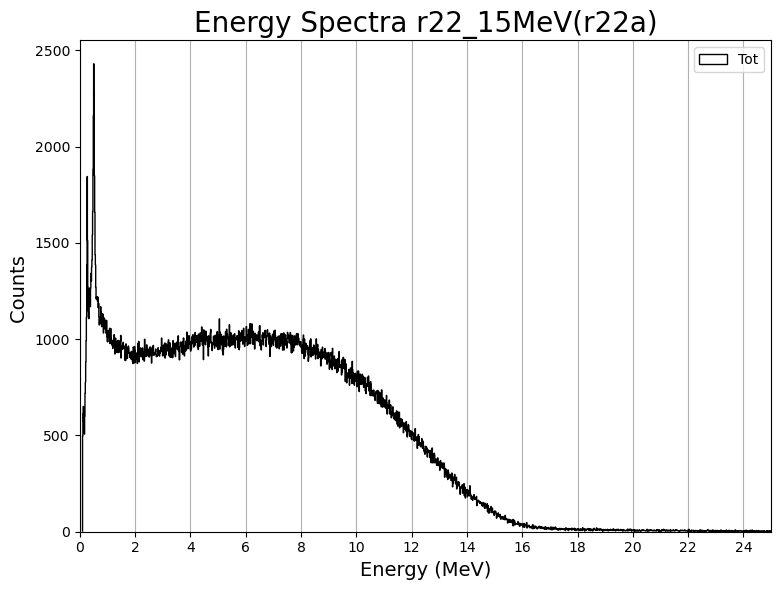

In [84]:
e_max = 25000
xlim_max = 25000

plt.rcParams["figure.figsize"] = [8, 6]  
# Combined
plt=reload(plt)
#lt.figure(figsize=(8,6))
tot, a, b= plt.hist(np.array(tot_nrg)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tot', histtype = 'step',color='Black',alpha=1)


#lt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,xlim_max/1000.0)
#plt.ylim(0,2000)
#plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,xlim_max/1000.0,2))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Total_{run}_{nrg}tot_MeV_log.jpeg")

### <font color='brown'> Plot : Energy Deposited Total

#### summed Plot

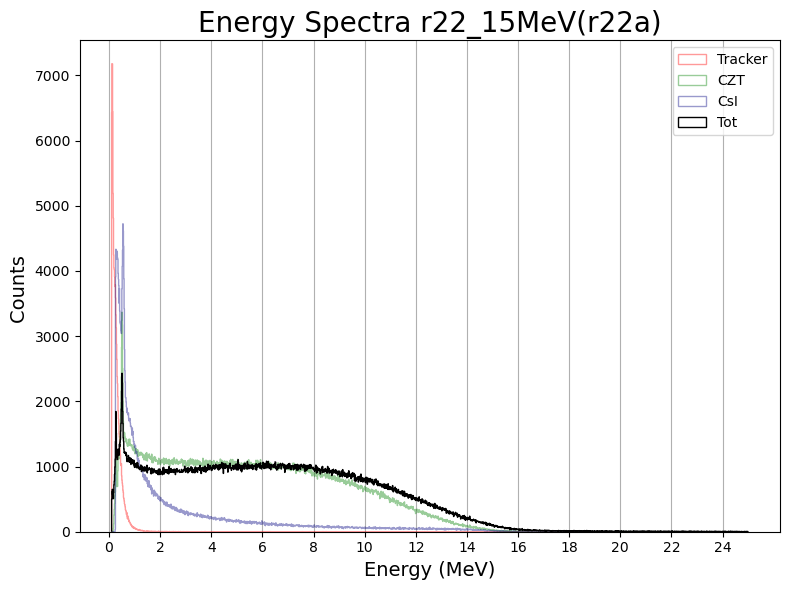

In [85]:
plt.rcParams["figure.figsize"] = [8, 6]  
# Combined
plt=reload(plt)
#lt.figure(figsize=(8,6))
trk_hist, a, b= plt.hist(np.array(Trk_nrg_sum_arr)/2000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red', alpha=0.4)
czt_hist, a, b=plt.hist(np.array(Czt_nrg_sum_arr)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='green',alpha=0.4)
csi_hist, a, b= plt.hist(np.array(Csi_nrg_sum_arr)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='navy',alpha=0.4)

tot, a, b= plt.hist(np.array(tot_nrg)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tot', histtype = 'step',color='Black',alpha=1)

#lt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
# plt.xlim(xlim_min/1000.0,xlim_max/1000.0)
# plt.ylim(0,200)
# plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,xlim_max/1000.0,2))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Total_{run}tot_a_{nrg}_MeV_log.jpeg")

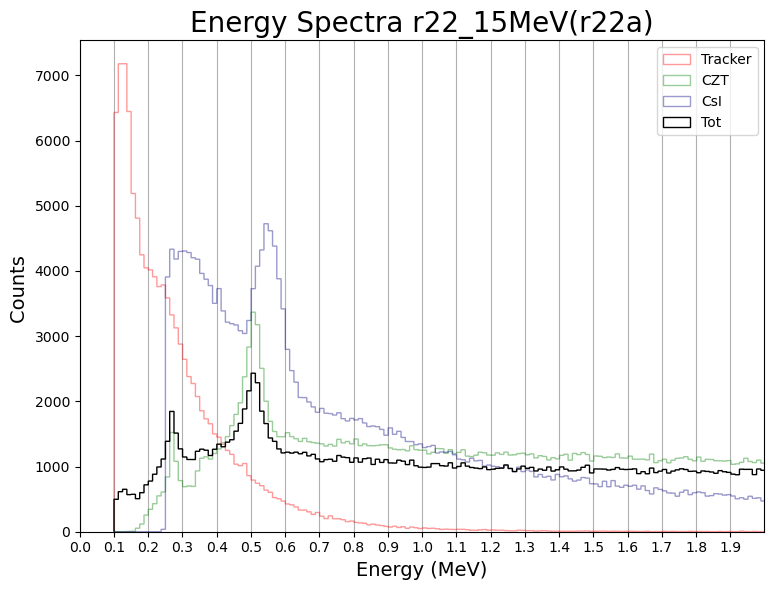

In [87]:
plt.rcParams["figure.figsize"] = [8, 6]  
# Combined
plt=reload(plt)
#lt.figure(figsize=(8,6))
trk_hist, a, b= plt.hist(np.array(Trk_nrg_sum_arr)/2000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red', alpha=0.4)
czt_hist, a, b=plt.hist(np.array(Czt_nrg_sum_arr)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='green',alpha=0.4)
csi_hist, a, b= plt.hist(np.array(Csi_nrg_sum_arr)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='navy',alpha=0.4)

tot, a, b= plt.hist(np.array(tot_nrg)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tot', histtype = 'step',color='Black',alpha=1)

#lt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,2)
#plt.ylim(0,2000)
# plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,2.0,0.1))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Total_{run}tot_b_{nrg}_MeV_log.jpeg")

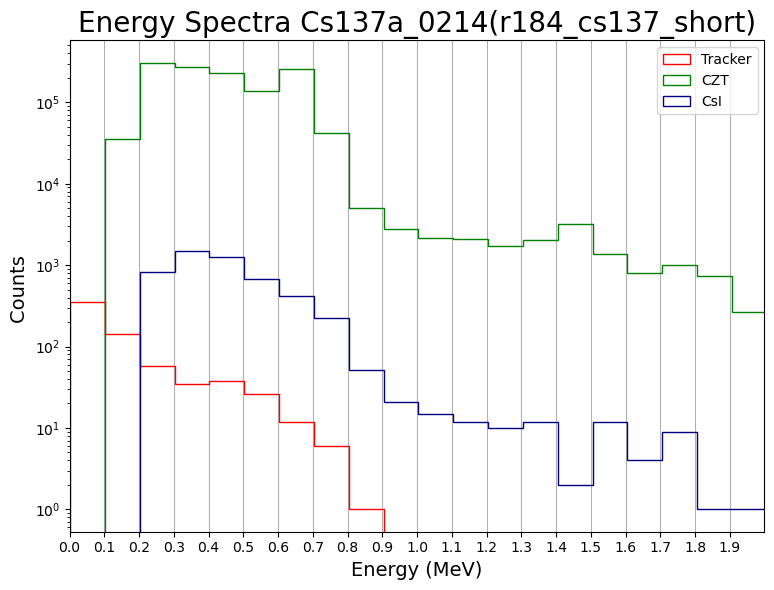

In [99]:
plt.rcParams["figure.figsize"] = [8, 6]  
# Combined
plt=reload(plt)
#lt.figure(figsize=(8,6))
trk_hist, a, b= plt.hist(np.array(Trk_nrg_sum_arr)/2000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red', alpha=1)
czt_hist, a, b=plt.hist(np.array(Czt_nrg_sum_arr)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='green',alpha=1)
csi_hist, a, b= plt.hist(np.array(Csi_nrg_sum_arr)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='navy',alpha=1)

# if com_evt_flag:
#     plt.hist(np.array(Tot_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0),histtype = 'step',label='Total', color='navy', linewidth=2)
# else:
#     plt.step(a[:-1],trk_hist+czt_hist+csi_hist,label='Total', color='navy', linewidth=2)

#test_t = trk_hist+czt_hist+csi_hist

#lt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,2)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,2,0.1))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Total_{run}_{nrg}c_MeV_log.jpeg")

#### secondary summed plot

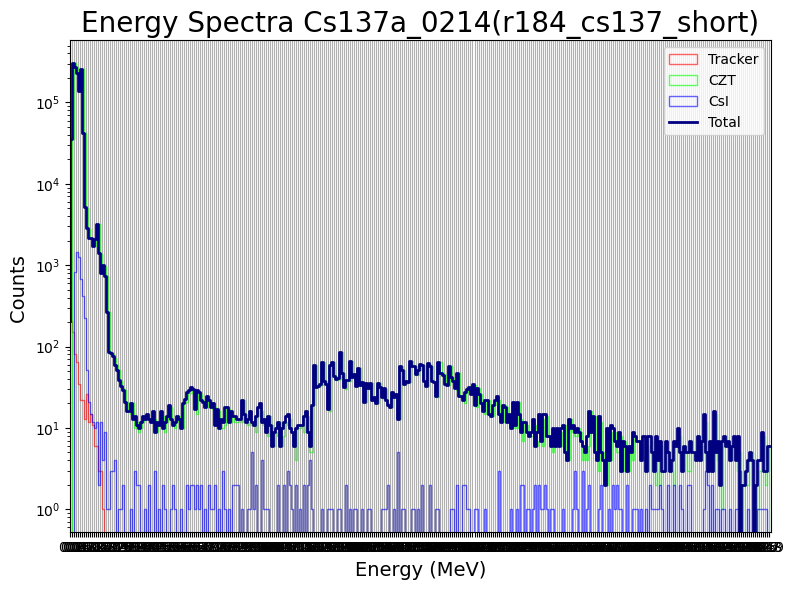

In [100]:
plt.rcParams["figure.figsize"] = [8, 6]  
# Combined
plt=reload(plt)
#lt.figure(figsize=(8,6))
trk_hist, a, b= plt.hist(np.array(Trk_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red', alpha=0.6)
czt_hist, a, b=plt.hist(np.array(Czt_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='lime',alpha=0.6)
csi_hist, a, b= plt.hist(np.array(Csi_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='blue',alpha=0.6)

if com_evt_flag:
    plt.hist(np.array(Tot_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0),histtype = 'step',label='Total', color='navy', linewidth=2)
else:
    tot_hist = plt.step(a[:-1],trk_hist+czt_hist+csi_hist,label='Total', color='navy', linewidth=2)
    
#test_t = trk_hist+czt_hist+csi_hist

#lt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,xlim_max/1000.0)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,xlim_max/1000.0,0.1))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Total_a_{run}_{nrg}MeV_log.jpeg")

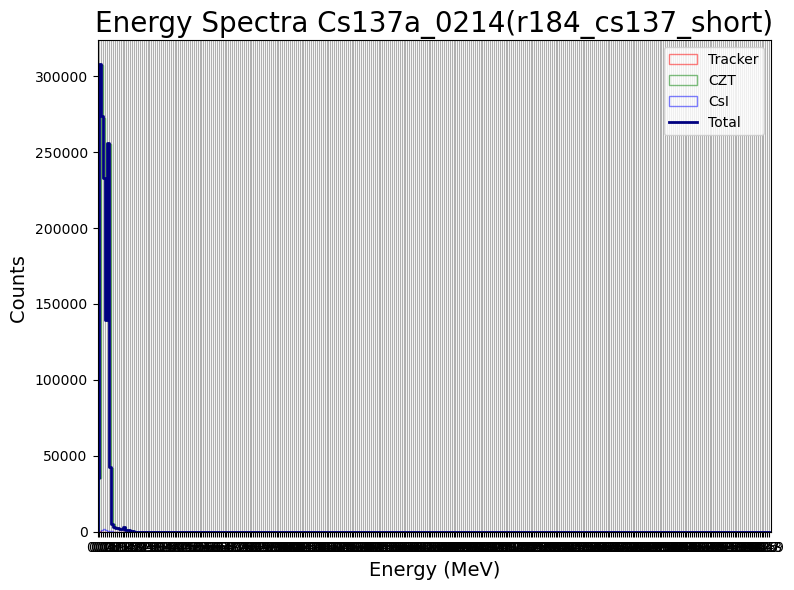

In [101]:
plt.rcParams["figure.figsize"] = [8, 6]   
# Combined
plt=reload(plt)
#plt.figure(figsize=(8,6))
trk_hist, a, b= plt.hist(np.array(Trk_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red', alpha=0.5)
czt_hist, a, b=plt.hist(np.array(Czt_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='green',alpha=0.5)
csi_hist, a, b= plt.hist(np.array(Csi_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='blue',alpha=0.5)

if com_evt_flag:
    plt.hist(np.array(Tot_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0),histtype = 'step',label='Total', color='navy', linewidth=2)
else:
    tot_hist = plt.step(a[:-1],trk_hist+czt_hist+csi_hist,label='Total', color='navy', linewidth=2)
#test_t = trk_hist+czt_hist+csi_hist

#plt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,xlim_max/1000.0)
#plt.ylim(0,2000)
#plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,xlim_max/1000.0,0.1))
plt.legend()
plt.savefig(f"{fpath}NrgDep_Total_{run}_{nrg}MeV.jpeg")

## <font color='brown'> Plot: All together

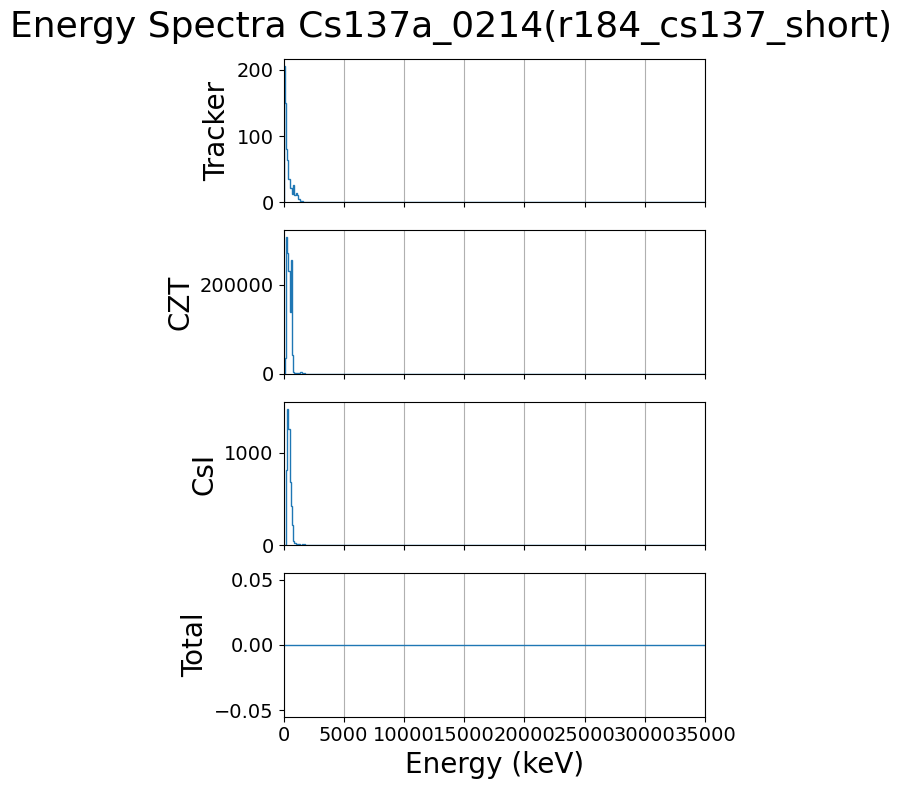

In [102]:
plt.rcParams["figure.figsize"] = [6, 8]   
fig, ax =  plt.subplots(4, sharex=True)

ax[0].hist(Trk_nrg_list, bins=n_bins, range=(e_min, e_max), label='Tracker', histtype='step')
ax[0].set_ylabel("Tracker", fontsize=20)

ax[1].hist(Czt_nrg_list, bins=n_bins, range=(e_min, e_max), label='CZT', histtype='step')
ax[1].set_ylabel("CZT", fontsize=20)

ax[2].hist(Csi_nrg_list, bins=n_bins, range=(e_min, e_max), label='CsI', histtype='step')
ax[2].set_ylabel("CsI", fontsize=20)

ax[3].hist(Tot_nrg_list, bins=n_bins, range=(e_min, e_max),histtype = 'step',label='Total')
ax[3].set_ylabel("Total", fontsize=20)

for axs in ax:
    axs.tick_params(axis='y', labelsize=14)
    axs.tick_params(axis='x', labelsize=14)
    axs.grid(axis='x')

plt.xlim(xlim_min,xlim_max)
#plt.xlim(0,7000)
plt.xlabel(x_label,fontsize='20')
fig.suptitle(f"{p_title}", size = 26)
plt.tight_layout()    
plt.savefig(f"{fpath}{p_title}.jpeg")

## <font color='brown'> Plot: Total Energy

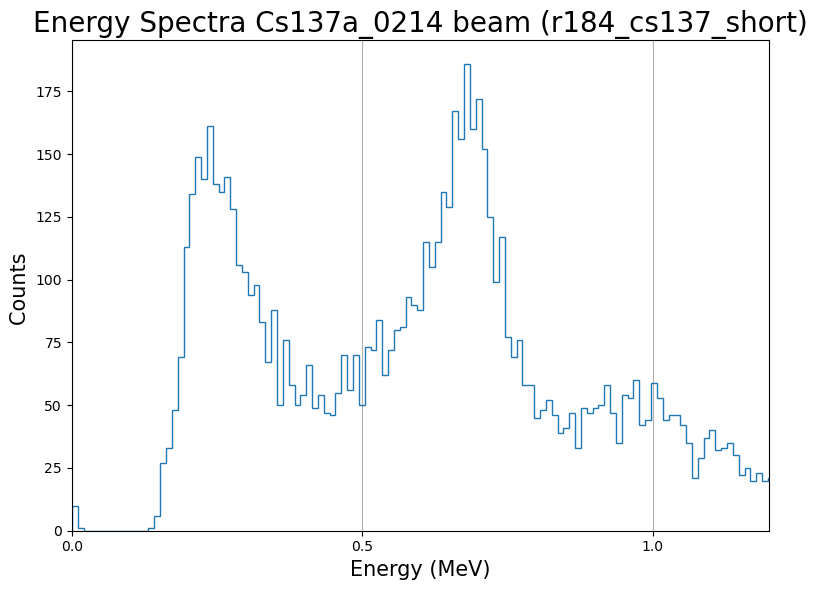

In [100]:
plt.rcParams["figure.figsize"] = [8, 6]
tot_hist, a, b = plt.hist(np.array(Tot_nrg_list)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0),histtype = 'step')
plt.xlabel('Energy (MeV)', fontsize='15')
plt.ylabel(y_label, fontsize='15')
plt.title(f'Energy Spectra {nrg} beam ({run})',fontsize='20')
plt.xlim(xlim_min/1000.0,1.2)
#plt.xlim(0,7000)

plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,xlim_max/1000.0,0.5))
plt.savefig(f"{fpath}summed_{run}.jpeg")

## <font color='brown'> Plot: EventID

In [101]:
file['Events/TKR/EventID'], file['Events/CZT/EventID'], file['Events/CsI/EventID/EventID']

(<HDF5 dataset "EventID": shape (9027,), type "<u4">,
 <HDF5 dataset "EventID": shape (9027,), type "<u4">,
 <HDF5 dataset "EventID": shape (9027,), type "<i8">)

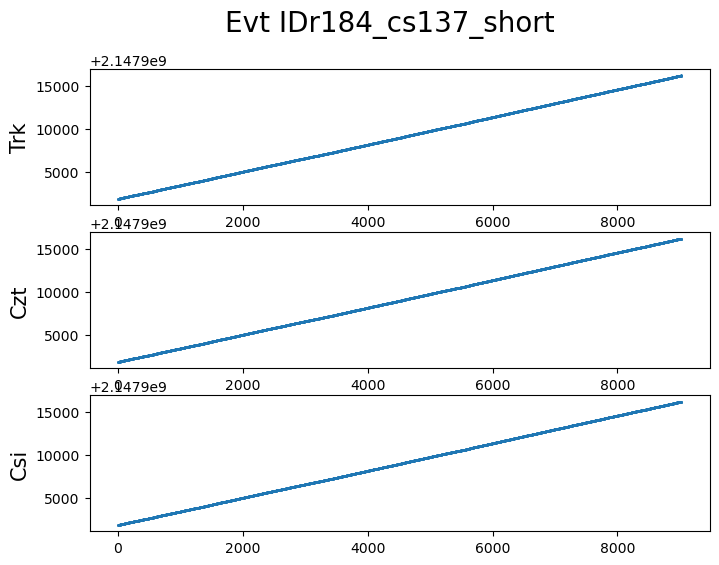

In [102]:
plt.rcParams["figure.figsize"] = [8, 6]  

fig, ax =  plt.subplots(3)

trk_id = file['Events/TKR/EventID'][...]
ax[0].scatter(np.arange(len(trk_id)),trk_id,marker='.',s=1)
ax[0].set_ylabel('Trk', fontsize='15')

czt_id = file['Events/CZT/EventID'][...]
ax[1].scatter(np.arange(len(czt_id)),czt_id,marker='.',s=1)
ax[1].set_ylabel('Czt', fontsize='15')

csi_id = file['Events/CsI/EventID/EventID'][...]
ax[2].scatter(np.arange(len(csi_id)),csi_id,marker='.',s=1)
ax[2].set_ylabel('Csi', fontsize='15')

plt.suptitle(f'Evt ID{run}', size=20)

plt.savefig(f"{fpath}gen_scatter_eventid_{run}_a1.jpeg")

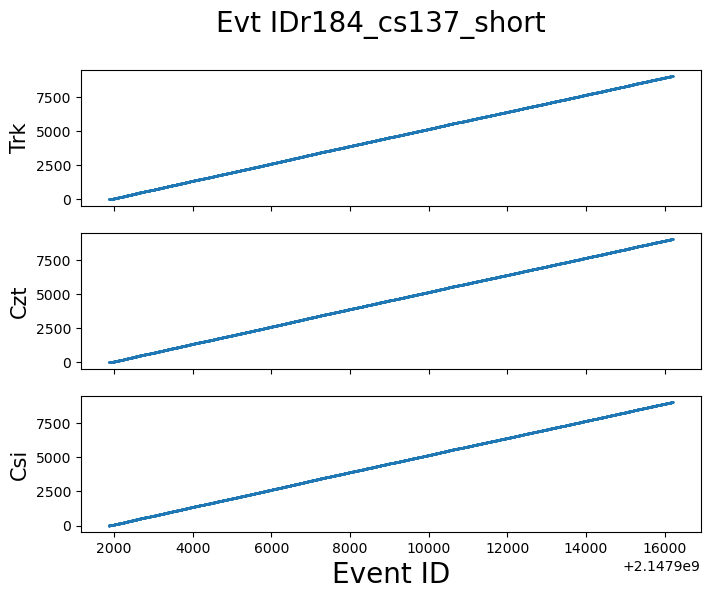

In [103]:
plt.rcParams["figure.figsize"] = [8, 6]  

fig, ax =  plt.subplots(3, sharex=True)

trk_id = file['Events/TKR/EventID'][...]
ax[0].scatter(trk_id,np.arange(len(trk_id)),marker='.',s=1)
ax[0].set_ylabel('Trk', fontsize='15')

czt_id = file['Events/CZT/EventID'][...]
ax[1].scatter(czt_id,np.arange(len(czt_id)),marker='.',s=1)
ax[1].set_ylabel('Czt', fontsize='15')

csi_id = file['Events/CsI/EventID/EventID'][...]
ax[2].scatter(csi_id,np.arange(len(csi_id)),marker='.',s=1)
ax[2].set_ylabel('Csi', fontsize='15')

plt.suptitle(f'Evt ID{run}', size=20)
plt.xlabel('Event ID',fontsize='20')
plt.savefig(f"{fpath}gen_scatter_eventid_{run}_a2.jpeg")

## <font color='brown'> Plot: Scatter: Tot dep vs Evt ID

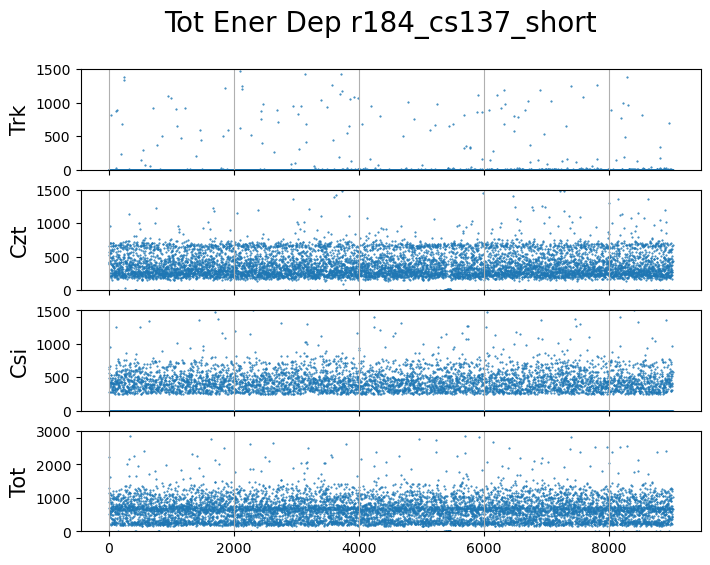

In [104]:
    
plt.rcParams["figure.figsize"] = [8, 6]  
max_ener = max_nrg_sel

total_nrg_sum_arr = Czt_nrg_sum_arr+Csi_nrg_sum_arr+(Trk_nrg_sum_arr/2.0)
fig, ax =  plt.subplots(4, sharex=True)

#Trk_evtid = file['Events/TKR/EventID'][...]
ax[0].scatter(np.arange(len(Trk_nrg_sum_arr)),Trk_nrg_sum_arr/2.0,marker='.',s=1)
ax[0].set_ylabel('Trk', fontsize='15')

#Czt_evtid= file['Events/CZT/EventID'][...]
ax[1].scatter(np.arange(len(Czt_nrg_sum_arr)),Czt_nrg_sum_arr,marker='.',s=1)
ax[1].set_ylabel('Czt', fontsize='15')

#Csi_evtid = file['Events/CsI/EventID/EventID'][...]
ax[2].scatter(np.arange(len(Csi_nrg_sum_arr)),Csi_nrg_sum_arr,marker='.',s=1)
ax[2].set_ylabel('Csi', fontsize='15')

for axs in ax:
    axs.set_ylim(0,max_ener)
    #axs.set_xlim(0,max(xvar))
    axs.grid(axis = 'x')    
    #axs.set_xticks(np.arange(0,max(xvar),20000))
    
ax[3].scatter(np.arange(len(Csi_nrg_sum_arr)),total_nrg_sum_arr,marker='.',s=1)
ax[3].set_ylim(0,2*max_ener)
ax[3].set_ylabel('Tot',fontsize='15')


#plt.xlabel('Event ID',fontsize='20')
plt.suptitle(f'Tot Ener Dep {run}', size=20)

plt.savefig(f"{fpath}gen_scatter_{run}_a.jpeg")

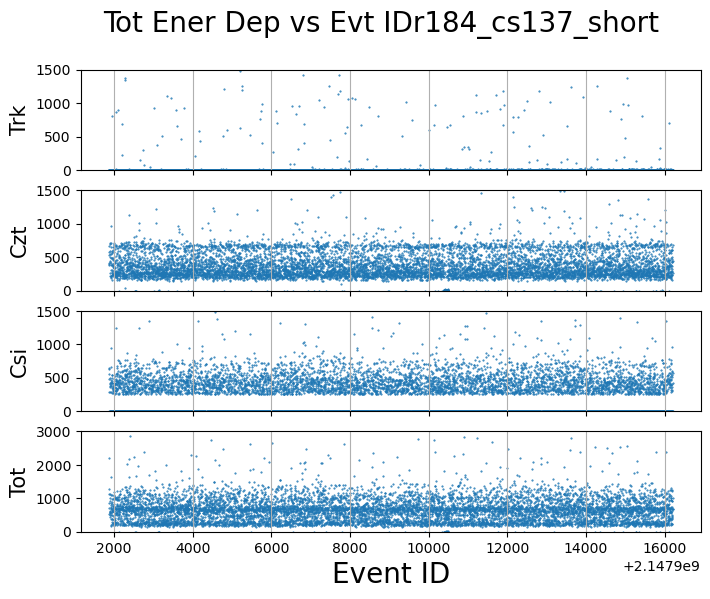

In [105]:
#plt.rcParams["figure.figsize"] = [12, 6]
max_ener = max_nrg_sel

total_nrg_sum_arr = Czt_nrg_sum_arr+Csi_nrg_sum_arr+(Trk_nrg_sum_arr/2.0)
fig, ax =  plt.subplots(4, sharex=True)

Trk_evtid = file['Events/TKR/EventID'][...]
ax[0].scatter(Trk_evtid,Trk_nrg_sum_arr/2.0,marker='.',s=1)
ax[0].set_ylabel('Trk', fontsize='15')

Czt_evtid= file['Events/CZT/EventID'][...]
ax[1].scatter(Czt_evtid,Czt_nrg_sum_arr,marker='.',s=1)
ax[1].set_ylabel('Czt', fontsize='15')

Csi_evtid = file['Events/CsI/EventID/EventID'][...]
ax[2].scatter(Csi_evtid,Csi_nrg_sum_arr,marker='.',s=1)
ax[2].set_ylabel('Csi', fontsize='15')

for axs in ax:
    axs.set_ylim(0,max_ener)
    #axs.set_xlim(0,max(xvar))
    axs.grid(axis = 'x')    
    #axs.set_xticks(np.arange(0,max(xvar),20000))
    
plt.rcParams["figure.figsize"] = [5,6]    
ax[3].scatter(Csi_evtid,total_nrg_sum_arr,marker='.',s=1)
ax[3].set_ylim(0,2*max_ener)
ax[3].set_ylabel('Tot',fontsize='15')


plt.xlabel('Event ID',fontsize='20')
plt.suptitle(f'Tot Ener Dep vs Evt ID{run}', size=20)

plt.savefig(f"{fpath}gen_scatter_{run}_b.jpeg")


## <font color='brown'> Plot: Scatter: Dep vs Evt Time

In [106]:
file['Events/CZT'].keys()

<KeysViewHDF5 ['ASICTemp', 'AnodePulseheight', 'AnodeTime', 'BadPadflag', 'CathodePulseheight', 'CathodeTime', 'CorUTC', 'Energy', 'EventID', 'EventTime', 'PadPulseheight', 'Position']>

In [107]:
file['Events/CZT/CorUTC']

<HDF5 dataset "CorUTC": shape (9027,), type "<f8">

In [108]:
len(Czt_nrg_sum_arr)

9027

In [109]:
file['Events/TKR/EventID'][...]

array([2147901872, 2147901874, 2147901875, ..., 2147916201, 2147916202,
       2147916203], dtype=uint32)

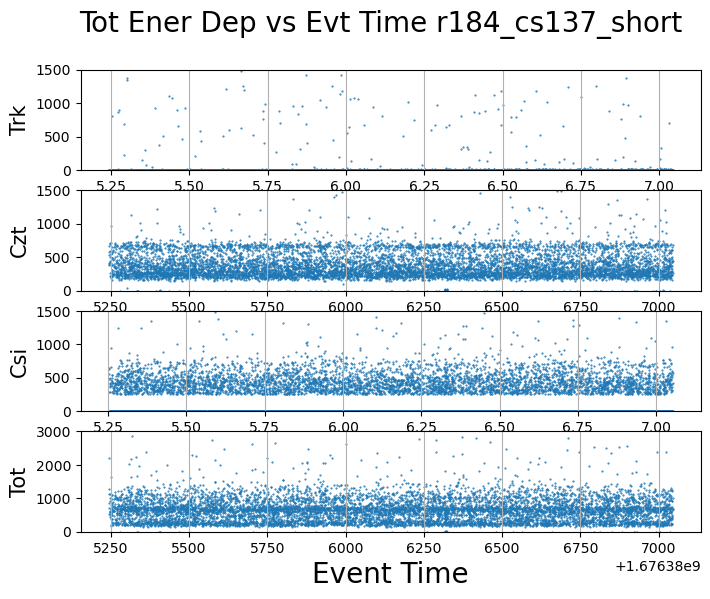

In [110]:
plt.rcParams["figure.figsize"] = [8, 6]  
max_ener = max_nrg_sel

total_nrg_sum_arr = Czt_nrg_sum_arr+Csi_nrg_sum_arr+(Trk_nrg_sum_arr/2.0)
trk_time = file['Events/TKR/EventTime'][...]
fig, ax =  plt.subplots(4)

ax[0].scatter(trk_time,Trk_nrg_sum_arr/2.0,marker='.',s=1)
ax[0].set_ylabel('Trk', fontsize='15')

czt_time = file['Events/CZT/CorUTC'][...]
#ax[1].scatter(czt_time,np.arange(len(czt_time)),marker='.',s=1)
ax[1].scatter(czt_time,Czt_nrg_sum_arr,marker='.',s=1)
ax[1].set_ylabel('Czt', fontsize='15')

csi_time = file['Events/CsI/time/UTC'][...]
ax[2].scatter(csi_time,Csi_nrg_sum_arr,marker='.',s=1)
ax[2].set_ylabel('Csi', fontsize='15')

for axs in ax:
    axs.set_ylim(0,max_ener)
    #axs.set_xlim(0,max(xvar))
    axs.grid(axis = 'x')    
    #axs.set_xticks(np.arange(0,max(xvar),20000))
    
plt.rcParams["figure.figsize"] = [12, 6]    
ax[3].scatter(czt_time,total_nrg_sum_arr,marker='.',s=1)
ax[3].set_ylim(0,2*max_ener)
ax[3].set_ylabel('Tot',fontsize='15')


plt.xlabel('Event Time',fontsize='20')
plt.suptitle(f'Tot Ener Dep vs Evt Time {run}', size=20)

plt.savefig(f"{fpath}gen_scatter_nrg_vs_time{run}_a.jpeg")

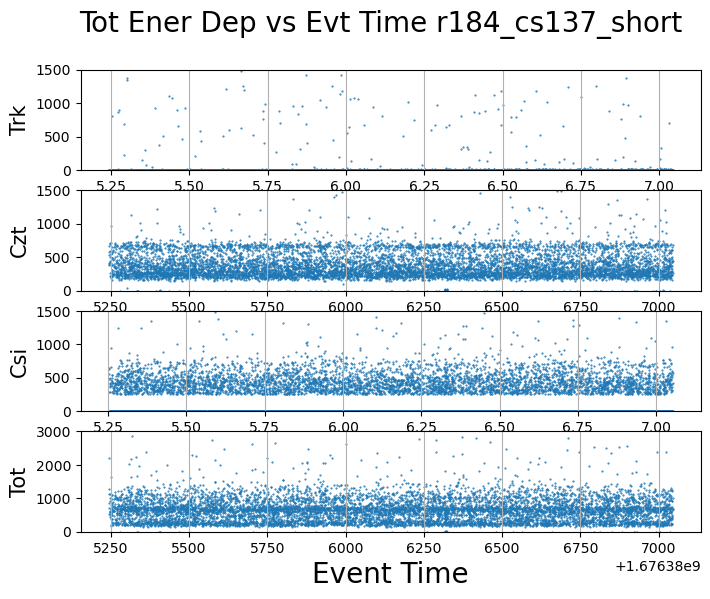

In [111]:
plt.rcParams["figure.figsize"] = [8, 6]  
max_ener = max_nrg_sel

total_nrg_sum_arr = Czt_nrg_sum_arr+Csi_nrg_sum_arr+(Trk_nrg_sum_arr/2.0)
trk_time = file['Events/TKR/EventTime'][...]
fig, ax =  plt.subplots(4)

ax[0].scatter(trk_time,Trk_nrg_sum_arr/2.0,marker='.',s=1)
ax[0].set_ylabel('Trk', fontsize='15')

czt_time = file['Events/CZT/CorUTC'][...]
#ax[1].scatter(czt_time,np.arange(len(czt_time)),marker='.',s=1)
ax[1].scatter(czt_time,Czt_nrg_sum_arr,marker='.',s=1)
ax[1].set_ylabel('Czt', fontsize='15')

csi_time = file['Events/CsI/time/UTC'][...]
ax[2].scatter(csi_time,Csi_nrg_sum_arr,marker='.',s=1)
ax[2].set_ylabel('Csi', fontsize='15')

for axs in ax:
    axs.set_ylim(0,max_ener)
    #axs.set_xlim(0,max(xvar))
    axs.grid(axis = 'x')    
    #axs.set_xticks(np.arange(0,max(xvar),20000))
    
plt.rcParams["figure.figsize"] = [12, 6]    
ax[3].scatter(czt_time,total_nrg_sum_arr,marker='.',s=1)
ax[3].set_ylim(0,2*max_ener)
ax[3].set_ylabel('Tot',fontsize='15')


plt.xlabel('Event Time',fontsize='20')
plt.suptitle(f'Tot Ener Dep vs Evt Time {run}', size=20)

plt.savefig(f"{fpath}gen_scatter_nrg_vs_time{run}_b.jpeg")

Event ID

In [112]:
file['Events/CsI/EventID'].keys()

<KeysViewHDF5 ['EventID']>

Time 

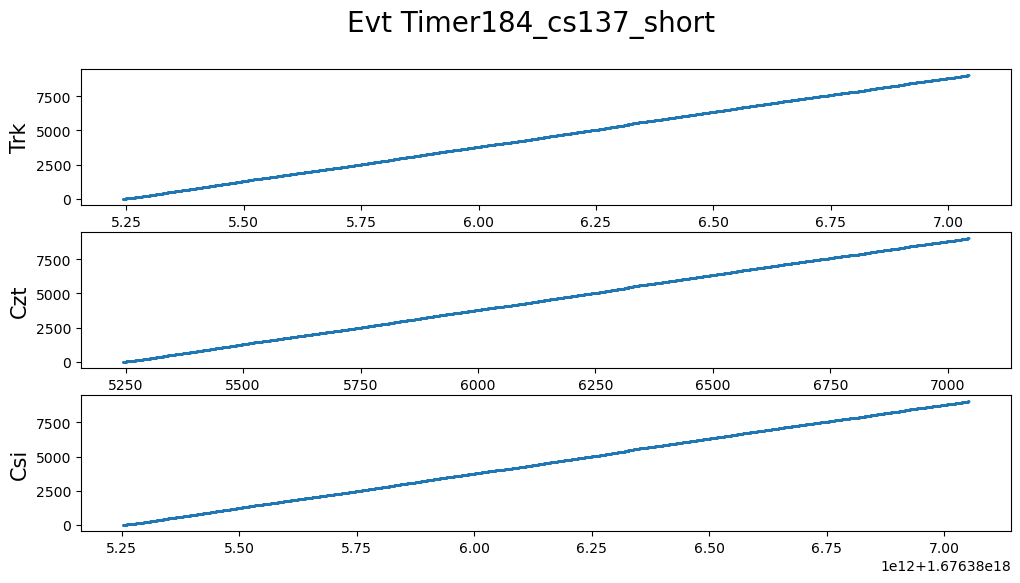

In [113]:
plt.rcParams["figure.figsize"] = [12, 6]

trk_time = file['Events/TKR/EventTime'][...]
fig, ax =  plt.subplots(3)


ax[0].scatter(trk_time,np.arange(len(trk_time)),marker='.',s=1)
ax[0].set_ylabel('Trk', fontsize='15')

czt_time = file['Events/CZT/CorUTC'][...]
ax[1].scatter(czt_time,np.arange(len(czt_time)),marker='.',s=1)
ax[1].set_ylabel('Czt', fontsize='15')

csi_time = file['Events/CsI/time/UTC'][...]
ax[2].scatter(csi_time,np.arange(len(csi_time)),marker='.',s=1)
ax[2].set_ylabel('Csi', fontsize='15')

#ax[3].set_ylabel('Count',fontsize='15')


#plt.xlabel('Event ID',fontsize='20')
plt.suptitle(f'Evt Time{run}', size=20)

plt.savefig(f"{fpath}gen_scatter_eventtime_{run}_a.jpeg")

In [114]:
np.min(csi_time)

1.6763852524121925e+18

In [115]:
np.max(csi_time)

1.676387052256762e+18

# Individual Subsystem Plots

## <font color='brown'> Plot: Tracker

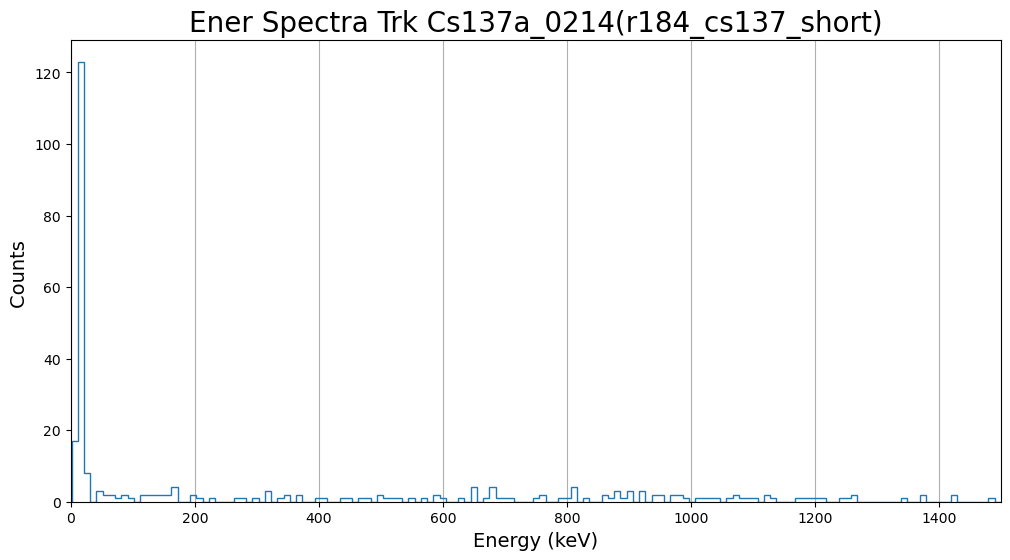

In [116]:
#fig = plt.hist(Trk_nrg_sum_arr,bins=n_bins,range=(e_min, e_max),label='Trk', histtype='step')
fig = plt.hist(Trk_nrg_list,bins=n_bins,range=(e_min, e_max),label='Trk', histtype='step')

t_title = f"Ener Spectra Trk {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlim(0,max_nrg_sel)
plt.grid(axis = 'x')
plt.savefig(f"{fpath}Spec_Trk_{run}.jpeg")

## <font color='brown'> Plot: CZT

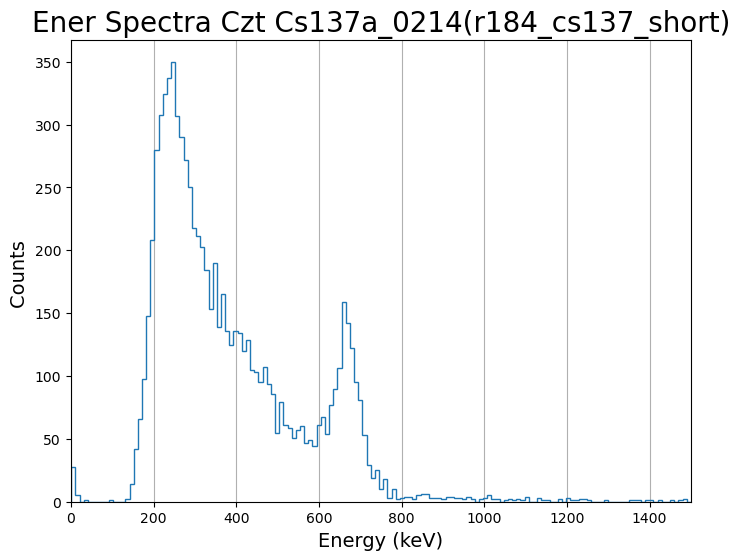

In [117]:
fig = plt.hist(Czt_nrg_list,bins=n_bins,range=(e_min, e_max),label='Czt', histtype='step')

t_title = f"Ener Spectra Czt {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlim(0,max_nrg_sel)
plt.grid(axis = 'x')
plt.savefig(f"{fpath}Spec_Czt_{run}.jpeg")

## <font color='brown'> Plot: CSI

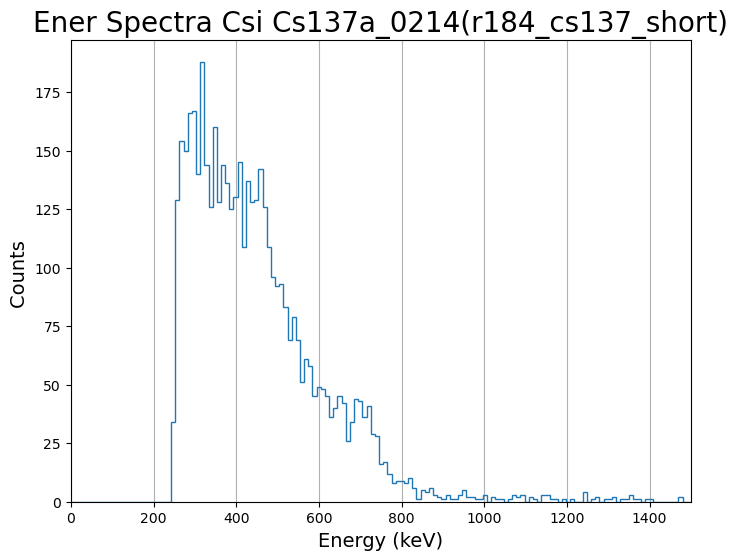

In [118]:
fig = plt.hist(Csi_nrg_sum_arr,bins=n_bins,range=(e_min, e_max),label='Csi', histtype='step')

t_title = f"Ener Spectra Csi {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlim(0,max_nrg_sel)
plt.grid(axis = 'x')
plt.savefig(f"{fpath}Spec_Csi_{run}.jpeg")

## <font color='brown'> Plot: CSI Mev

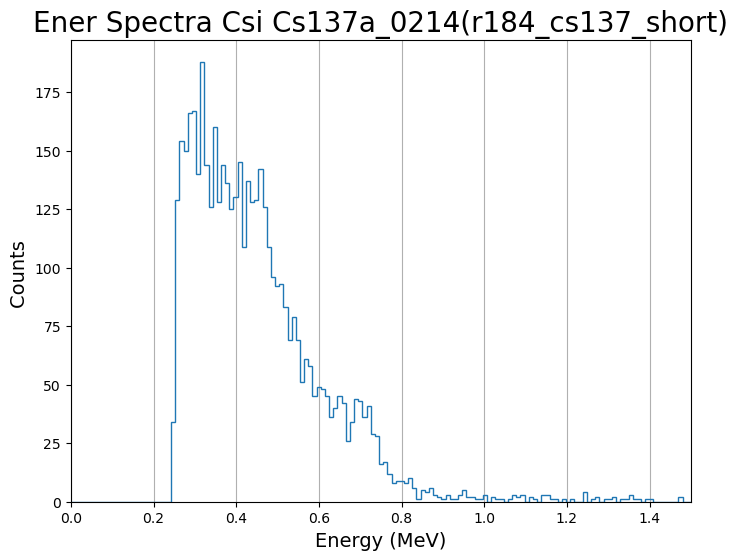

In [119]:
fig = plt.hist(Csi_nrg_sum_arr/1000.00,bins=n_bins,range=(e_min/1000.0, e_max/1000.0),label='Csi', histtype='step')

t_title = f"Ener Spectra Csi {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel('Energy (MeV)', size=14)
plt.ylabel(y_label, size=14)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlim(0,max_nrg_sel/1000.00)
plt.grid(axis = 'x')
plt.savefig(f"{fpath}Spec_Csi_{run}_mev.jpeg")

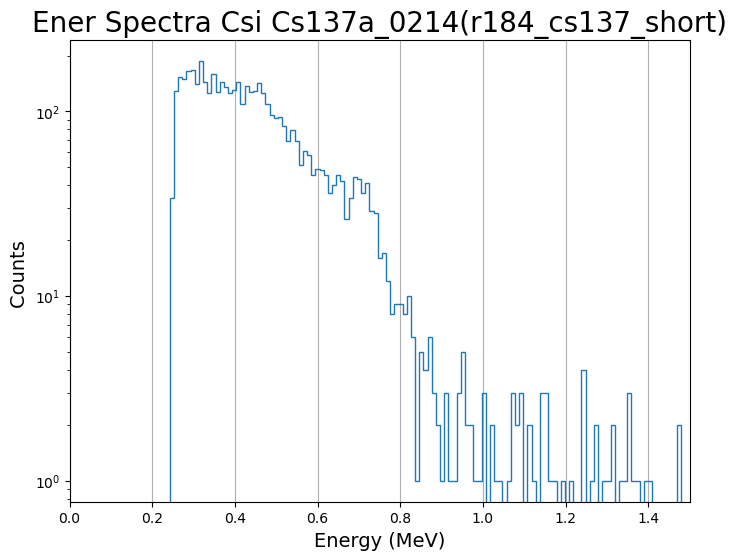

In [120]:
fig = plt.hist(Csi_nrg_sum_arr/1000.00,bins=n_bins,range=(e_min/1000.0, e_max/1000.0),label='Csi', histtype='step')

t_title = f"Ener Spectra Csi {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel('Energy (MeV)', size=14)
plt.ylabel(y_label, size=14)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlim(0,max_nrg_sel/1000.00)
plt.grid(axis = 'x')
plt.yscale('log')
plt.savefig(f"{fpath}Spec_Csi_{run}_mev_log.jpeg")

# <font color='blue'> Bivariate Plot

## <font color='brown'> Plot: CZT + CSI

In [121]:
bivar = 1000
n_bins

149

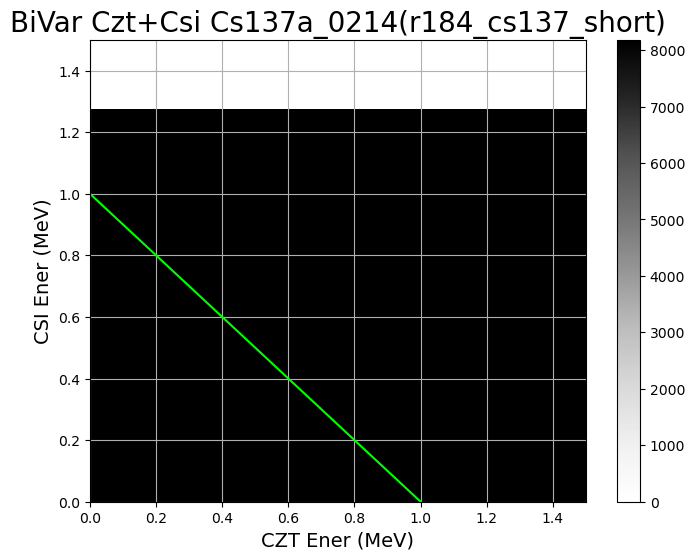

In [122]:
plt.rcParams["figure.figsize"] = [8, 6]
fig = plt.hist2d(Czt_nrg_sum_arr/1000.0, Csi_nrg_sum_arr/1000.0, bins=(n_bins, n_bins), cmap='Greys')
plt.xlim(0,max_ener/1000.0)
plt.ylim(0,max_ener/1000.0)
plt.colorbar()

t_title = f"BiVar Czt+Csi {nrg}({run})"
plt.title(t_title, size = 20)

plt.xlabel('CZT Ener (MeV)', size=14)
plt.ylabel('CSI Ener (MeV)', size=14)
#plt.set_aspect = 'equal'
plt.plot([0, bivar/1000.0], [bivar/1000.0, 0],color="lime")
plt.grid(axis = 'x')
plt.grid(axis = 'y')
plt.savefig(f"{fpath}bivar_cztcsi_{run}.jpeg")

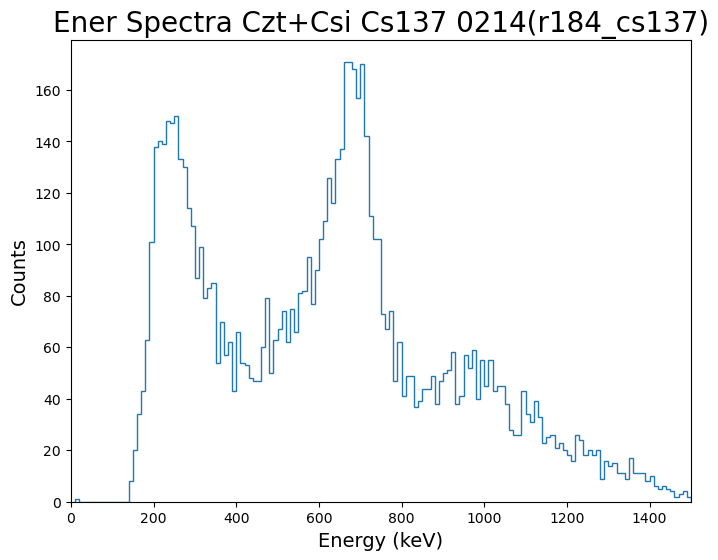

In [49]:
cztcsi_nrg_arr = Czt_nrg_sum_arr + Csi_nrg_sum_arr
fig = plt.hist(cztcsi_nrg_arr,bins=n_bins,range=(e_min, e_max),label='Czt+Csi', histtype='step')

t_title = f"Ener Spectra Czt+Csi {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)

plt.xlim(0,max_ener)

plt.savefig(f"{fpath}Ener_Spectra_cztcsi_{run}.jpeg")

## <font color='brown'> Plot: CZT + Tracker

In [50]:
binEnergyStep = 10
MIN_ADC = 0
MAX_ADC = max_ener
energyEdges = np.linspace(MIN_ADC, MAX_ADC, int((MAX_ADC-MIN_ADC)/binEnergyStep)  )
#energyEdges

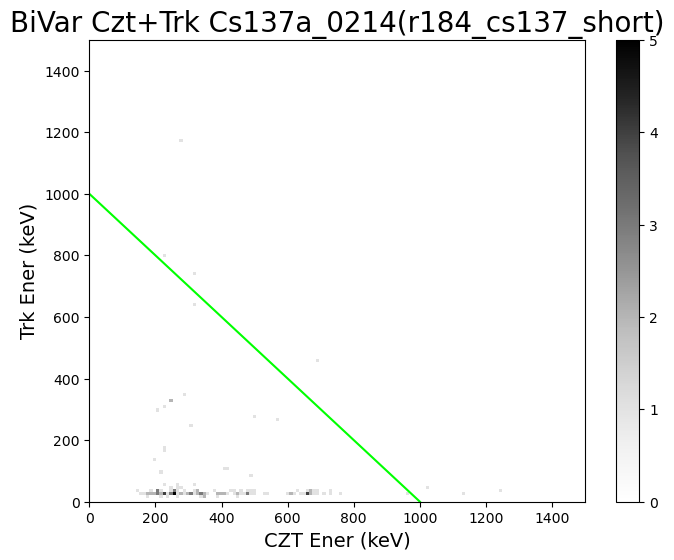

In [123]:
fig = plt.hist2d(Czt_nrg_sum_arr, Trk_nrg_sum_arr, bins=(n_bins, n_bins),range=((e_min, e_max),(e_min, e_max)), cmap='Greys',vmax=5)

plt.xlim(0,max_ener)
plt.ylim(0,max_ener)
plt.colorbar()

t_title = f"BiVar Czt+Trk {nrg}({run})"
plt.title(t_title, size = 20)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlabel('CZT Ener (keV)', size=14)
plt.ylabel('Trk Ener (keV)', size=14)
#plt.set_aspect = 'equal'
plt.plot([0, bivar], [bivar, 0],color="lime")

plt.savefig(f"{fpath}bivar_czttrk_{run}.jpeg")


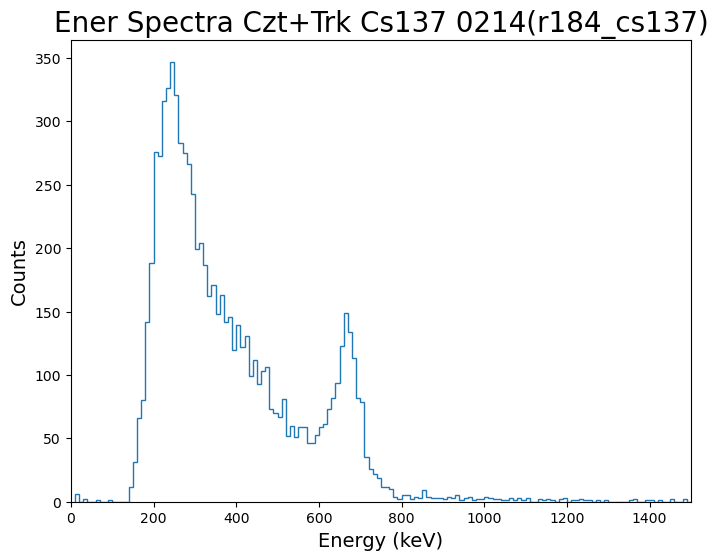

In [52]:
czttrk_nrg_arr = Czt_nrg_sum_arr + Trk_nrg_sum_arr
fig = plt.hist(czttrk_nrg_arr,bins=n_bins,range=(e_min, e_max),label='Czt+Trk', histtype='step')

t_title = f"Ener Spectra Czt+Trk {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)

plt.xlim(0,max_ener)
plt.savefig(f"{fpath}Ener_Spectra_czttrk_{run}.jpeg")

## <font color='brown'> Plot:  TRK + CSI

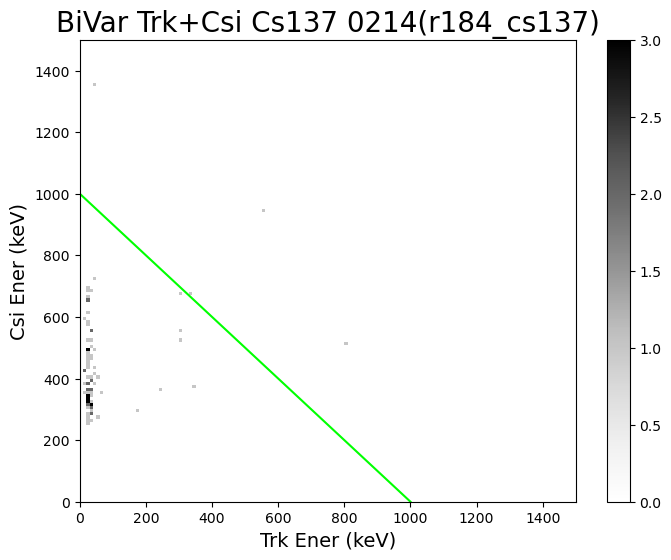

In [53]:
fig = plt.hist2d(Trk_nrg_sum_arr, Csi_nrg_sum_arr, bins=(n_bins, n_bins),range=((e_min, e_max),(e_min, e_max)), cmap='Greys')

plt.xlim(0,max_ener)
plt.ylim(0,max_ener)
plt.colorbar()

t_title = f"BiVar Trk+Csi {nrg}({run})"
plt.title(t_title, size = 20)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlabel('Trk Ener (keV)', size=14)
plt.ylabel('Csi Ener (keV)', size=14)
#plt.set_aspect = 'equal'
plt.plot([0, bivar], [bivar, 0],color="lime")

plt.savefig(f"{fpath}bivar_trkcsi_{run}.jpeg")

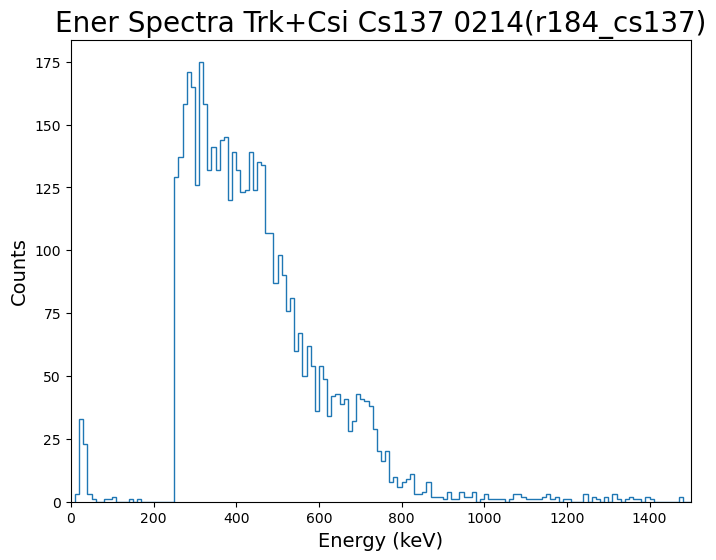

In [54]:
trkcsi_nrg_arr = Trk_nrg_sum_arr + Csi_nrg_sum_arr
fig = plt.hist(trkcsi_nrg_arr,bins=n_bins,range=(e_min, e_max),label='Trk+Csi', histtype='step')

t_title = f"Ener Spectra Trk+Csi {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)

plt.xlim(0,max_ener)
#plt.xlim(0,4000)
plt.savefig(f"{fpath}Ener_Spectra_trkcsi_{run}.jpeg")

# <font color='blue'>Fitting the plot

### Mid x-value

In [55]:
temp_x = np.linspace(e_min, e_max, n_bins)
#for i in range(len(tot_hist)):
x_data= []
for i in range(len(temp_x)):
    xmid = (a[i]+a[i+1])/2.0
    x_data.append(xmid)

print(len(x_data))
print(len(temp_x))


149
149


### function

In [56]:
def gaussian_func(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c , 2)))

### starting values

In [57]:
##### Estimates
amplitude = 1000
mean = 2100
SD = 100

### Fitting and plot

149
149
[1000. 2100.  100.]


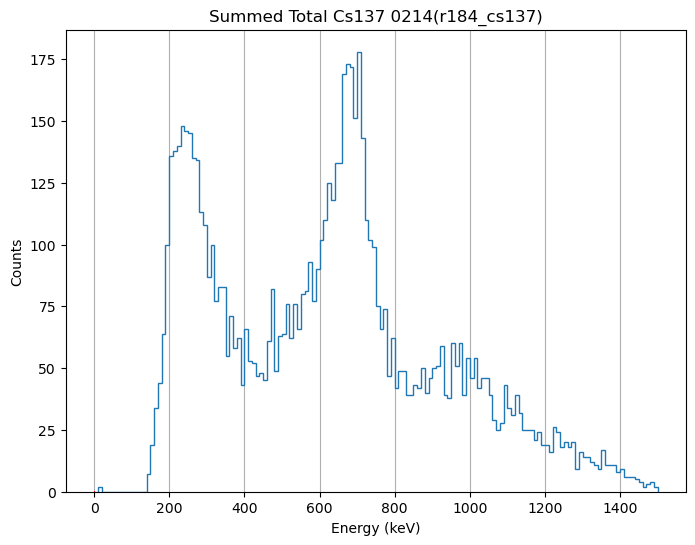

In [58]:
tot_hist, a, b = plt.hist(Tot_nrg_list, bins=n_bins, range=(e_min, e_max),histtype = 'step')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(f'Summed Total {nrg}({run})')
#plt.xlim(xlim_min,xlim_max)
plt.rcParams["figure.figsize"] = [8, 6]


print(len(x_data))
print(len(tot_hist))

pars, pcov = curve_fit(f=gaussian_func, xdata=x_data, ydata=tot_hist, p0=[amplitude,mean,SD])
y_gauss = gaussian_func(x_data, pars[0], pars[1], pars[2])

plt.plot(x_data, y_gauss,'r--');                  
plt.grid(axis = 'x')
print(pars)

ValueError: `ydata` must not be empty!

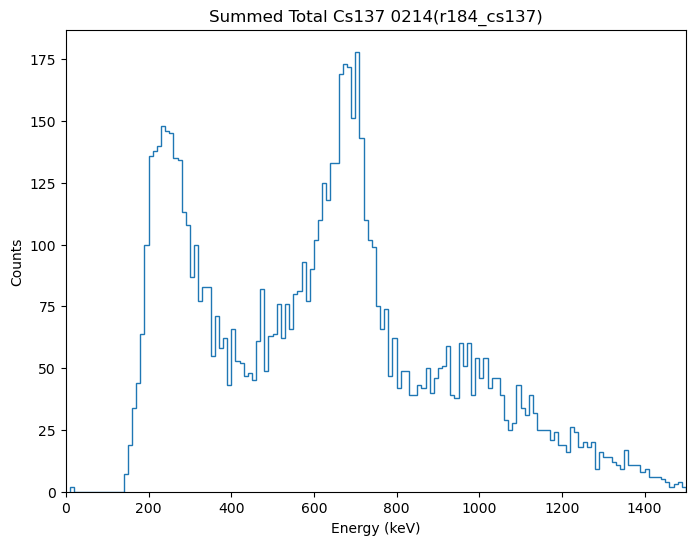

In [59]:
#%matplotlib qt
tot_hist, a, b = plt.hist(Tot_nrg_list, bins=n_bins, range=(e_min, e_max),histtype = 'step', label='beam data')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(f'Summed Total {nrg}({run})')
plt.xlim(xlim_min,xlim_max)
plt.rcParams["figure.figsize"] = [10, 8]

# Narrow fit

low_x = 190
hi_x = 220

x_data1 = x_data[low_x:hi_x] 
y_data1 = tot_hist[low_x:hi_x] 

pars, pcov = curve_fit(f=gaussian_func, xdata=x_data1, ydata=y_data1, p0=[amplitude,mean,SD])
y_gauss1 = gaussian_func(x_data1, pars[0], pars[1], pars[2])
perr = np.sqrt(np.diag(pcov))
plt.plot(x_data1, y_gauss1,'r--', label=f'Gauss fit: a={pars[0]:5.1f} ({perr[0]:3.1f}) , b={pars[1]:5.1f} ({perr[1]:3.1f}), c={pars[2]:5.1f} ({perr[2]:3.1f})') 
print(pars)
print(perr)
plt.xlabel(x_label, fontsize='15')
plt.ylabel(y_label, fontsize='15')
plt.title(f'Summed Total {nrg}({run})',fontsize='20')
plt.legend()
plt.grid(axis = 'x')
plt.savefig(f"{fpath}tot_fitted_{run}.jpeg")

# Investigate

## <mark> <font color='red'> Gain Issue

In [ ]:
plt.rcParams["figure.figsize"] = [12, 6]
max_ener = max_nrg_sel

total_nrg_sum_arr = Czt_nrg_sum_arr/1000.0 +Csi_nrg_sum_arr/1000.0 +Trk_nrg_sum_arr/2000.0 
xvar = np.arange(n_evts)
fig, ax =  plt.subplots(4, sharex=True)

ax[0].scatter(xvar,Trk_nrg_sum_arr/2000.0,marker='.',s=1)
ax[0].set_ylabel('Trk', fontsize='15')

ax[1].scatter(xvar,Czt_nrg_sum_arr/1000.0,marker='.',s=1)
ax[1].set_ylabel('Czt', fontsize='15')

ax[2].scatter(xvar,Csi_nrg_sum_arr/1000.0,marker='.',s=1)
ax[2].set_ylabel('Csi', fontsize='15')

for axs in ax:
    axs.set_ylim(0,max_ener/1000.0)
    axs.set_xlim(0,max(xvar))
    axs.grid(axis = 'x')    
    axs.set_xticks(np.arange(0,max(xvar),20000))
    axs.set_yticks(np.arange(0,max_ener/1000.0,1))
    
plt.rcParams["figure.figsize"] = [12, 6]    
ax[3].scatter(xvar,total_nrg_sum_arr,marker='.',s=1)
ax[3].set_ylim(0,1.5*max_ener/1000.0)
ax[3].set_ylabel('Tot',fontsize='15')
#[3].set_yticks(np.arange(0,max(total_nrg_sum_arr),1))

plt.xlabel('Event ID',fontsize='20')
plt.suptitle(f'Tot Ener Dep vs Evt ID {run}', size=20)

#plt.savefig(f"{fpath}gen_scatter_{run}_mev.jpeg")

> <font color='red'>  Notes
    
* Looks like some form of gain change. 
* The y axis is total energy deposited in the subsystem for that event. 


### Divide the data and look at those event ids

In [ ]:
len(Trk_nrg_sum_arr), len(Csi_nrg_sum_arr)

In [ ]:
s_id = 180000 # id to split the data

In [ ]:
Trk_half_a = Trk_nrg_sum_arr[0:s_id]/2.0
Csi_half_a = Csi_nrg_sum_arr[0:s_id]
Czt_half_a = Czt_nrg_sum_arr[0:s_id]

Trk_half_b = Trk_nrg_sum_arr[s_id:]/2.0
Csi_half_b = Csi_nrg_sum_arr[s_id:]
Czt_half_b = Czt_nrg_sum_arr[s_id:]

In [ ]:
len(Trk_half_a), len(Trk_half_b)

In [ ]:
Tot_nrg_a = Trk_half_a+Csi_half_a+Czt_half_a
Tot_nrg_b = Trk_half_b+Csi_half_b+Czt_half_b

In [ ]:
# Combined
plt=reload(plt)
plt.figure(figsize=(8,6))
trk_hist, a, b= plt.hist(np.array(Trk_half_a)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red')
czt_hist, a, b= plt.hist(np.array(Czt_half_a)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='lime')
csi_hist, a, b= plt.hist(np.array(Csi_half_a)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='blue')

plt.hist(np.array(Tot_nrg_a)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0),histtype = 'step',label='Total', color='navy')

#test_t = trk_hist+czt_hist+csi_hist

plt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,max_nrg_sel/1000.0)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,max_nrg_sel/1000.0,0.2))
plt.legend()
plt.savefig(f"{fpath}debug_TotNrg_a_R{run}_{nrg}MeV_log.jpeg")

In [ ]:
# Combined
plt=reload(plt)
plt.figure(figsize=(8,6))
trk_hist, a, b= plt.hist(np.array(Trk_half_b)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Tracker', histtype = 'step',color='red')
czt_hist, a, b= plt.hist(np.array(Czt_half_b)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CZT', histtype = 'step', color='lime')
csi_hist, a, b= plt.hist(np.array(Csi_half_b)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='CsI', histtype = 'step',color='blue')

plt.hist(np.array(Tot_nrg_b)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0),histtype = 'step',label='Total', color='navy')

#test_t = trk_hist+czt_hist+csi_hist

plt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,max_nrg_sel/1000.0)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,max_nrg_sel/1000.0,0.2))
plt.legend()
plt.savefig(f"{fpath}debug_TotNrg_b_R{run}_{nrg}MeV_log.jpeg")

In [ ]:
# Combined
plt=reload(plt)
plt.figure(figsize=(8,6))
trk_hista, a, b= plt.hist(np.array(Trk_half_a)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Trk A', histtype = 'step',color='red')
trk_histb, a, b= plt.hist((np.array(Trk_half_b)/1000.0), bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Trk B', histtype = 'step', color='blue')

#test_t = trk_hist+czt_hist+csi_hist

plt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,max_nrg_sel/1000.0)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,max_nrg_sel/1000.0,0.2))
plt.legend()
plt.savefig(f"{fpath}debug_Trk_R{run}_{nrg}MeV_log.jpeg")

In [ ]:
# Combined
plt=reload(plt)
plt.figure(figsize=(8,6))
csi_hista, a, b= plt.hist(np.array(Csi_half_a)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Csi A', histtype = 'step',color='red')
csi_histb, a, b= plt.hist(np.array(Csi_half_b)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Csi B', histtype = 'step', color='blue')

#test_t = trk_hist+czt_hist+csi_hist

plt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,max_nrg_sel/1000.0)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,max_nrg_sel/1000.0,0.2))
plt.legend()
plt.savefig(f"{fpath}debug_Csi_R{run}_{nrg}MeV_log.jpeg")

In [ ]:
# Combined
plt=reload(plt)
plt.figure(figsize=(8,6))
czt_hista, a, b= plt.hist(np.array(Czt_half_a)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Czt A', histtype = 'step',color='red')
czt_histb, a, b= plt.hist(np.array(Czt_half_b)/1000.0, bins=n_bins, range=(e_min/1000.0, e_max/1000.0), label='Czt B', histtype = 'step', color='blue')

#test_t = trk_hist+czt_hist+csi_hist

plt.rcParams["figure.figsize"] = [6, 8]
plt.xlabel("Energy (MeV)", size=14)
plt.ylabel(y_label, size=14)
plt.title(p_title, size = 20)
plt.xlim(xlim_min/1000.0,max_nrg_sel/1000.0)
#plt.ylim(0,2000)
plt.yscale('log')
plt.tight_layout()
plt.grid(axis = 'x')
plt.xticks(np.arange(0,max_nrg_sel/1000.0,0.2))
plt.legend()
plt.savefig(f"{fpath}debug_CZT_R{run}_{nrg}MeV_log.jpeg")

## <mark><font color='red'> Tracker Investigate


In [ ]:
Trk_nrg = file['Events/TKR/Energy'][...]
print(Trk_nrg.shape)
Trk_nrg_arr = Trk_nrg.sum(axis = tuple(range(1,4)) )
Trk_nrg_arr.shape

> Look at energies, below 50 and seee what energies they are, what event id, what layer, etc,,.

In [ ]:
fig = plt.hist(Trk_nrg_arr,bins=n_bins,range=(e_min, e_max),label='Trk', histtype='step')

t_title = f"Ener Spectra Trk {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlim(0,4000)

In [ ]:
fig = plt.hist(Trk_nrg_arr,bins=n_bins,range=(e_min, e_max),label='Trk', histtype='step')

t_title = f"Ener Spectra Trk {nrg}({run})"
plt.title(t_title, size = 20)
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.rcParams["figure.figsize"] = [8, 6]
plt.xlim(0,100)

In [ ]:
print(e_min, e_max)

In [ ]:
temp_nrg = 10.00
temp_evtid_list =[]
for i in range(Trk_nrg_arr.shape[0]):
    if 0.0 < Trk_nrg_arr[i] < temp_nrg :
        temp_evtid_list.append(i)
        print(i, Trk_nrg_arr[i])

In [ ]:
temp_id = temp_evtid_list[0]
temp_id

In [ ]:
Trk_nrg_evt = file['Events/TKR/Energy'][10455,...]
Trk_nrg_evt.shape

In [ ]:
loc_list = np.argwhere(Trk_nrg_evt > 0.0)

## Energy Coefficient File

In [ ]:
ecalib_file = "/Users/swasti/Downloads/EnergyCalibrationCoefficients_20220420.dat"

In [ ]:
with open(ecalib_file) as efile:
    lines=efile.readlines()

In [ ]:
flag_array = np.zeros(())

In [ ]:
lines

In [ ]:
flag_arr = np.zeros((10,2,192),dtype=int)
skipline=14  # 14 works
with open(ecalib_file) as efile:

    for _ in range(skipline):
        next(efile)

    for line in efile:
        str_arr = str.split(line)
        flag_arr[int(str_arr[0]),int(str_arr[1]),int(str_arr[2])] = int(str_arr[3])


In [ ]:
flag_arr[0,0,0:10]

### Ecalib file flag plots.

In [ ]:
# Focusing one layer. 
#Layer = 0
#one_layer_a = flag_arr[Layer,0,:]
#one_layer_b = flag_arr[Layer,1,:]

In [ ]:
#one_layer_a.shape

In [ ]:
#x=np.arange(192)
#figa = plt.scatter(x,one_layer_a, c=one_layer_a)

### Check the flag for the low energy det.

In [ ]:
loc_list

In [ ]:
det1 = loc_list[0]
print(Trk_nrg_evt[det1[0],det1[1],det1[2]])
flag_arr[det1[0],det1[1],det1[2]]

In [ ]:
det2 = loc_list[1]
print(Trk_nrg_evt[det2[0],det2[1],det2[2]])
flag_arr[det2[0],det2[1],det2[2]]

# Triggers

In [ ]:
file.keys()

# Run 1 SIT_AND_HIT, TM Mode 4,7,A,C


In [ ]:
file['Summary/Trigger'].keys()

In [ ]:
file['Summary/Trigger'].keys()

In [ ]:
for keys in file['Summary/Trigger'].keys():
    print(f'-----------{keys}')
    print(file[f"Summary/Trigger/{keys}"][...])
    print('----------')

In [ ]:
file['Summary/Trigger/axis0'][...]

In [ ]:
file['Summary/Trigger/block0_items'][...]

In [ ]:
file['Summary/Trigger/block0_items']

In [ ]:
file['Summary/Trigger/block0_items'][0]

In [ ]:
file['Summary/Trigger/block0_values']

In [ ]:
blk0_cohitrw= file['Summary/Trigger/block0_values'][:,0]
blk0_cohitrw

In [ ]:
file['Summary/Trigger/block0_items'][1]

In [ ]:
blk0_cohitcd= file['Summary/Trigger/block0_values'][:,1]
blk0_cohitcd

In [ ]:
file['Summary/Trigger/axis0']

In [ ]:
file['Summary/Trigger/axis1']

In [ ]:
file['Summary/Trigger/block1_values']

In [ ]:
file['Summary/Trigger/block0_values']

In [ ]:
trg_evtid= file['Summary/Trigger/block1_values'][:,0]

In [ ]:
trg_cohitcd = file['Summary/Trigger/block0_values'][:,1]
trg_cohitrw = file['Summary/Trigger/block0_values'][:,0]

In [ ]:
np.unique(trg_cohitcd)

In [ ]:
np.unique(trg_cohitrw)

In [ ]:
x = np.arange(trg_evtid.shape[0])
sel = 1000

fig = plt.scatter(x[0:sel],trg_cohitrw[0:sel])

In [ ]:
sel_val = (trg_cohitrw == 16)

fig = plt.scatter(trg_evtid[sel_val],trg_cohitrw[sel_val])

In [ ]:
sel_val

# Quick tests

In [ ]:
#evtid = 16897
evtid = 4761

In [ ]:
csi_ener_arr = file['Events/CsI/erg'][evtid,:]
csi_ener_arr

In [ ]:
file['Events/CZT/Energy'][evtid,:,:]>0.0

In [ ]:
file['Events/CZT/Energy'][evtid,:,:]

# Check attributes

In [ ]:
fname = file_dict['run8']
file = h5py.File(fname,'r')

In [ ]:
#temp_dict = dict(file.attrs.items())
#temp_dict

In [ ]:
temp_dict = dict(file.attrs.items())
temp_dict

In [ ]:
temp = file['Events/TKR'].keys()
temp

In [ ]:
file['Summary'].keys()

In [ ]:
tdict = dict(file['Events/TKR/'].attrs.items())
tdict

# Testing CSI logs

In [ ]:
evtid = 4761

csi_ene_arr = file['Events/CsI/erg'][evtid,:]
csi_pos_arr = file['Events/CsI/pos'][evtid,:]
csi_ene_arr


In [ ]:
file['Events/CsI/pos']

In [ ]:
csi_pos_arr

In [ ]:
rowPos = np.linspace(0, 5, 6) * 1.9
rowPos = rowPos - np.mean(rowPos)

layerPos = np.linspace(0, 4, 5) * 1.9
layerPos = layerPos-np.max(layerPos)-11.172-1.67/2

rowPos

In [ ]:
layerPos

In [ ]:
for layer in range(0, 5):
    for row in range(0, 6):
        logNumber = layer * 6 + row
        print(f'LOG = {logNumber}, Layer= {layer}, Row = {row}')
        if csi_ene_arr[logNumber] > 0:
            if (layer % 2 == 0):
                xpos = float(-csi_pos_arr[logNumber])/10.0
                ypos = rowPos[row]
            else:
                xpos = rowPos[row]
                ypos = float(-csi_pos_arr[logNumber])/10.0

            zpos = layerPos[4 - layer]
            ene = csi_ene_arr[logNumber]

            print(f'{float(ene)}')
            print(f'{float(xpos)}')
            print(f'{float(ypos)}')
            print(f'{float(zpos)}')